In [9]:
import os, sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import itertools
%matplotlib inline 

import torch
import torch.nn as nn
import torchvision
import gc
import random
import seaborn as sns
import torchvision.datasets as datasets
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, TensorDataset
from src import distributions
from src.tools import unfreeze, freeze
from src.tools import weights_init_D
from src.tools import fig2data, fig2img
from src.guided_samplers import Sampler, PairedSubsetSampler, SubsetGuidedDataset, get_indicies_subset
from src.moons_utils import generate_moon_dataset, plot_twomoon
from tqdm import tqdm_notebook as tqdm

## Init Parameters

In [2]:
NUM_LABELED = 10
T_ITERS = 10
BATCH_SIZE = 32
С_SIZE = 2
#real batch size is BATCH_SIZE*С_SIZE
NUM_MODES = 4

D_LR, T_LR = 1e-4, 1e-4
PLOT_INTERVAL = 100
CPKT_INTERVAL = 1000
MAX_STEPS = 1001
SEED = 0x000001
torch.manual_seed(SEED); np.random.seed(SEED)

## Build Moons dataset

In [3]:
xs, ys, xt, yt, range_sub = generate_moon_dataset(90, n_samples=500, random_state=45, use_pair=True)
xs_test, ys_test, xt_test, yt_test, range_sub = generate_moon_dataset(90, n_samples=150, random_state=45, use_pair=True)

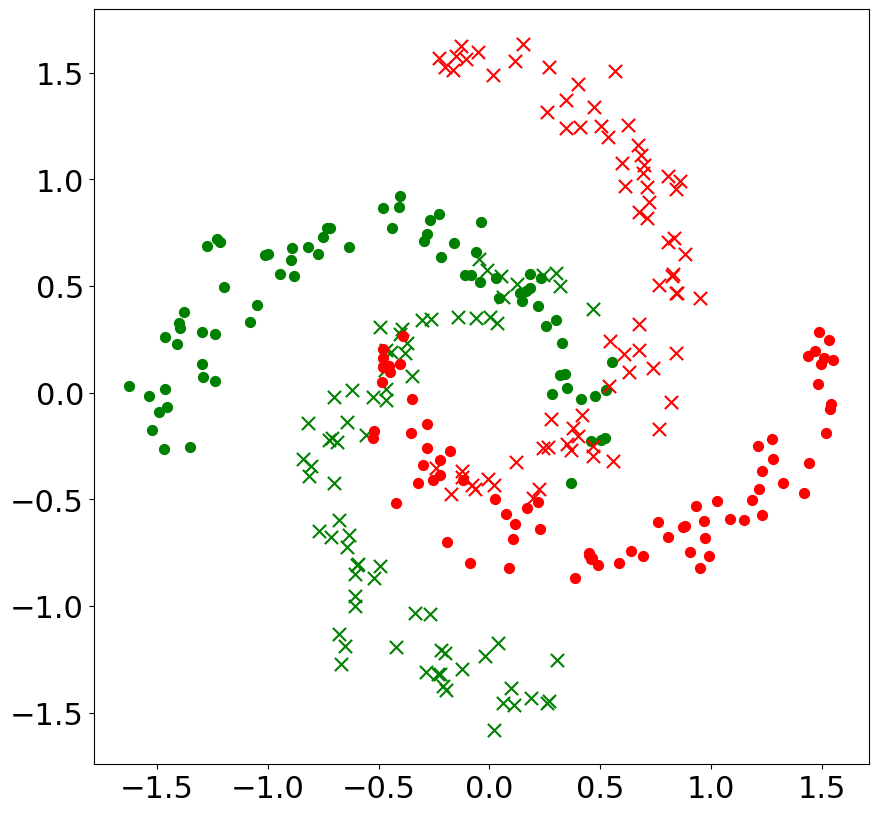

In [4]:
plot_twomoon(xs_test, xt_test, show_lines = False, name='Input-Traget', save_path = None)

In [10]:
source_classes = torch.tensor(list(range(0,2)))
source_labels = {i.item():i.item() for i in source_classes}
target_classes = torch.tensor(list(range(0,2)))
target_labels = {i.item():i.item() for i in target_classes}

In [11]:
source_train = TensorDataset(torch.from_numpy(xs).float(), torch.from_numpy(ys).long())
source_loader = DataLoader(source_train, batch_size=BATCH_SIZE, shuffle=True)
subset_samples, labels, source_class_indicies = get_indicies_subset(source_train, 
                                                                    new_labels=source_labels, 
                                                                    classes=len(source_classes), 
                                                                    subset_classes=source_classes)
source_train =  TensorDataset(torch.stack(subset_samples), torch.LongTensor(labels))

target_train = TensorDataset(torch.from_numpy(xt).float(), torch.from_numpy(yt).long())
target_loader = DataLoader(target_train, batch_size=BATCH_SIZE, shuffle=True)
target_subset_samples, target_labels, target_class_indicies = get_indicies_subset(target_train, 
                                                                                  new_labels =target_labels, 
                                                                                  classes=len(target_classes), 
                                                                                  subset_classes=target_classes)
target_train = TensorDataset(torch.stack(target_subset_samples), torch.LongTensor(target_labels))

train_set = SubsetGuidedDataset(source_train, target_train, 
                                num_labeled=NUM_LABELED, 
                                in_indicies = source_class_indicies, 
                                out_indicies = target_class_indicies)
full_set = SubsetGuidedDataset(source_train, target_train, 
                               num_labeled='all', 
                               in_indicies = source_class_indicies, 
                               out_indicies = target_class_indicies)

T_XY_sampler = PairedSubsetSampler(train_set, subsetsize=С_SIZE)
D_XY_sampler = PairedSubsetSampler(full_set, subsetsize=1)

## Init Networks

In [7]:
class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

T = FeedForward(2, 128, 2).cuda()
D = FeedForward(2, 128, 1).cuda()
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
D_opt = torch.optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)

## Start Training

  0%|          | 0/1001 [00:00<?, ?it/s]

Plotting results
T Loss: 1.0052815675735474
D Loss: -0.012987418100237846


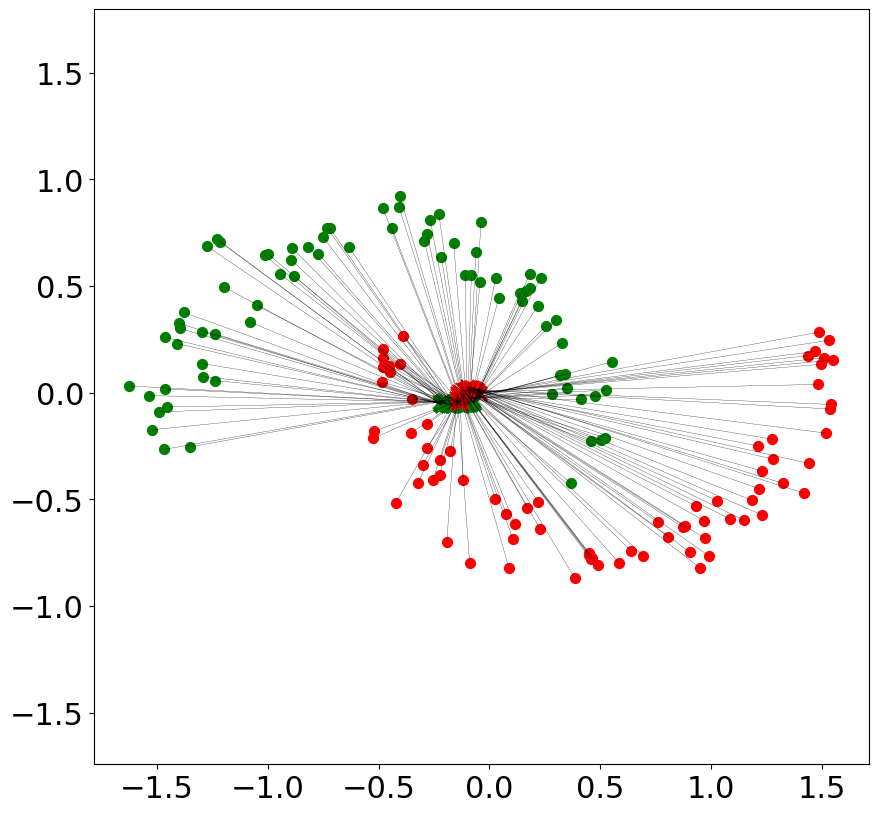

Plotting results
T Loss: 0.3915482759475708
D Loss: 0.007713593542575836


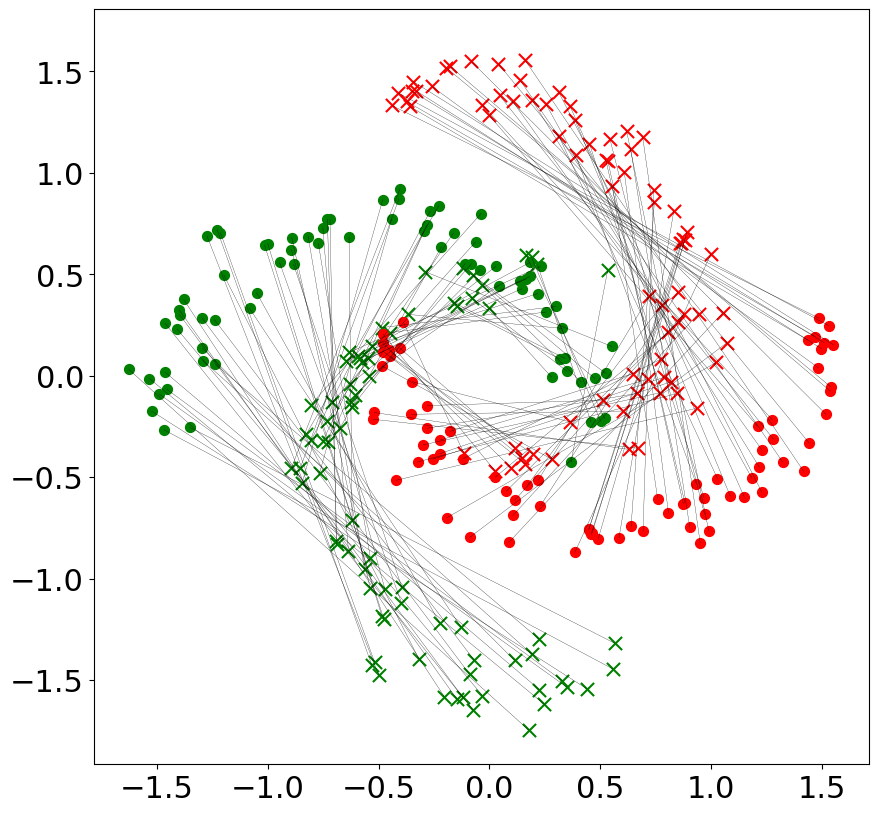

Plotting results
T Loss: 0.46157318353652954
D Loss: -0.008964033797383308


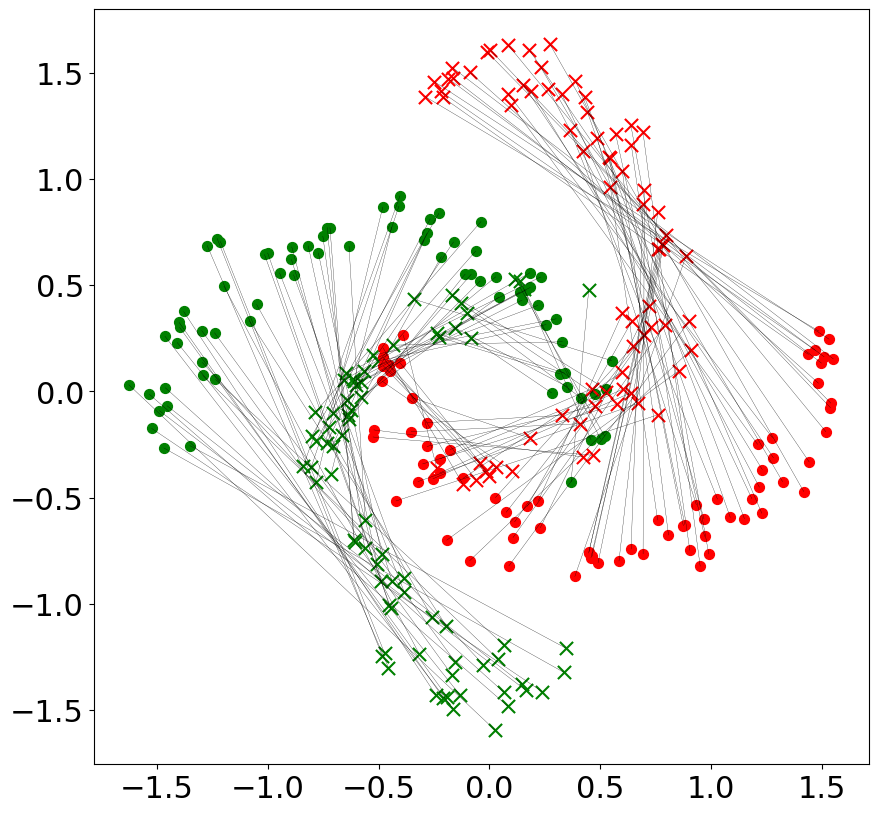

Plotting results
T Loss: 0.5083183646202087
D Loss: -0.060939569026231766


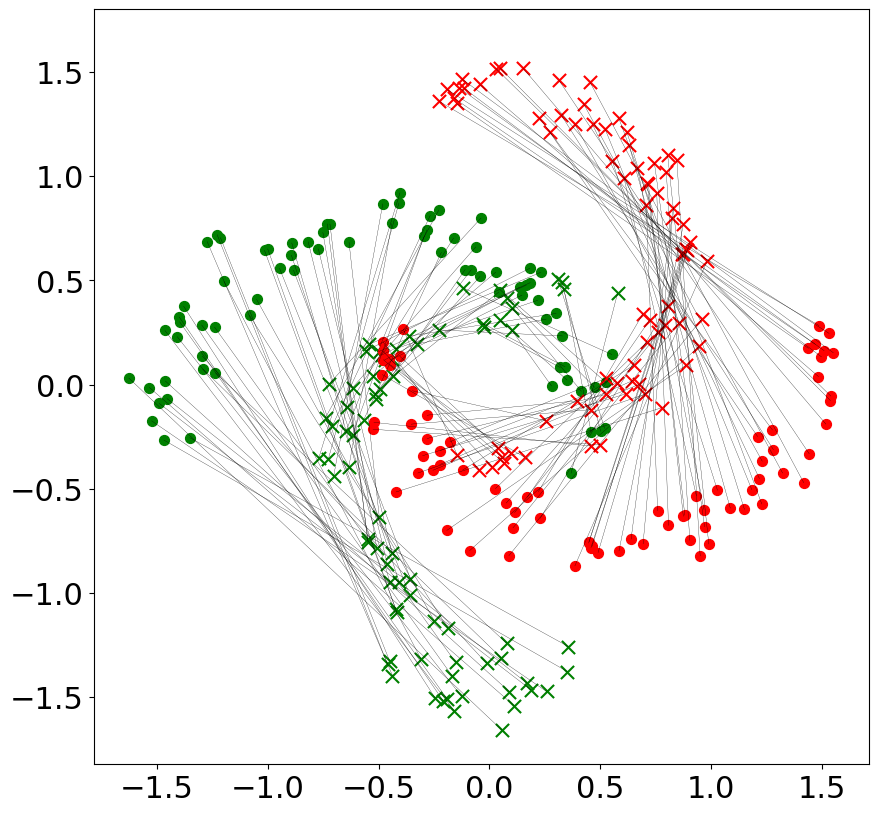

Plotting results
T Loss: 0.42199721932411194
D Loss: 0.014954008162021637


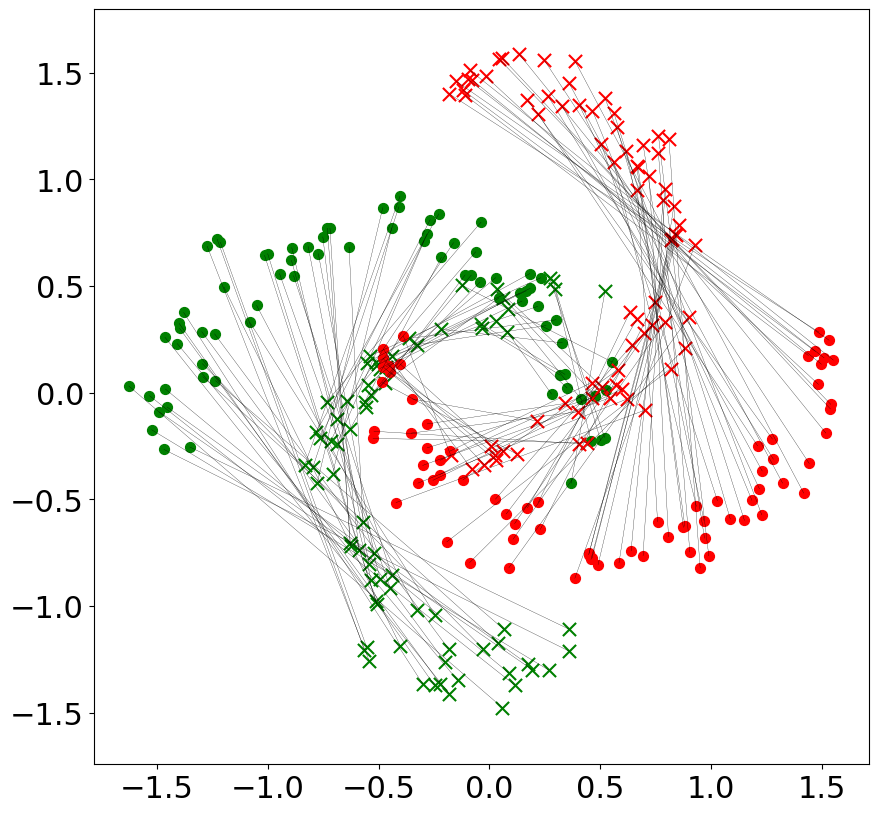

Plotting results
T Loss: 0.683832585811615
D Loss: -0.024928823113441467


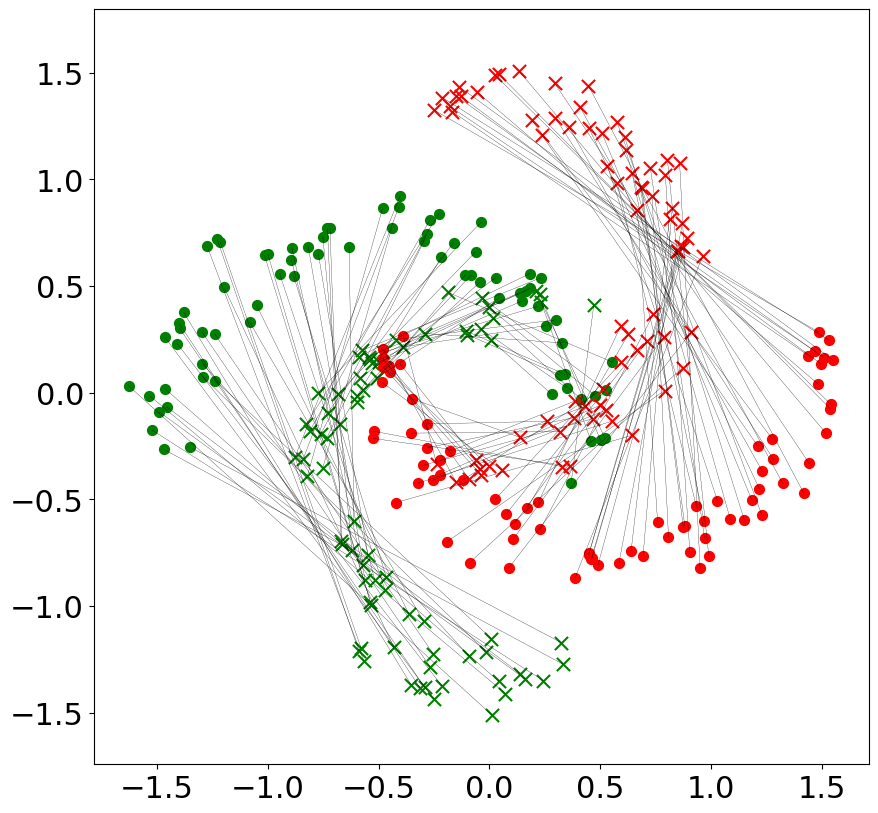

Plotting results
T Loss: 0.4691014885902405
D Loss: -0.06168360635638237


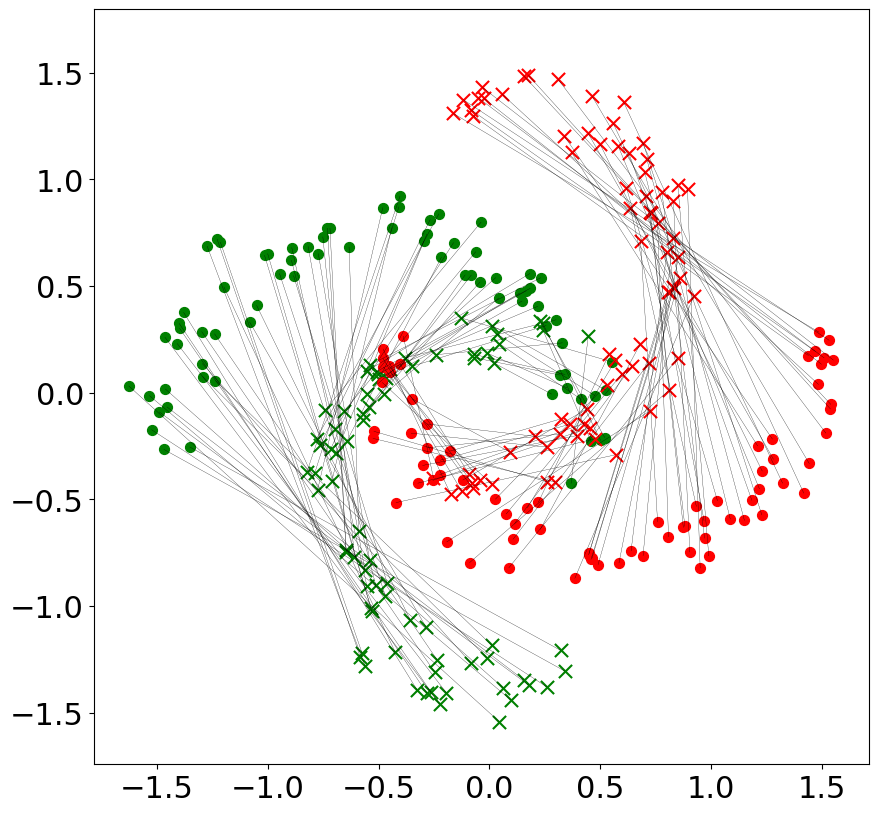

Plotting results
T Loss: 0.40174466371536255
D Loss: -0.0460260808467865


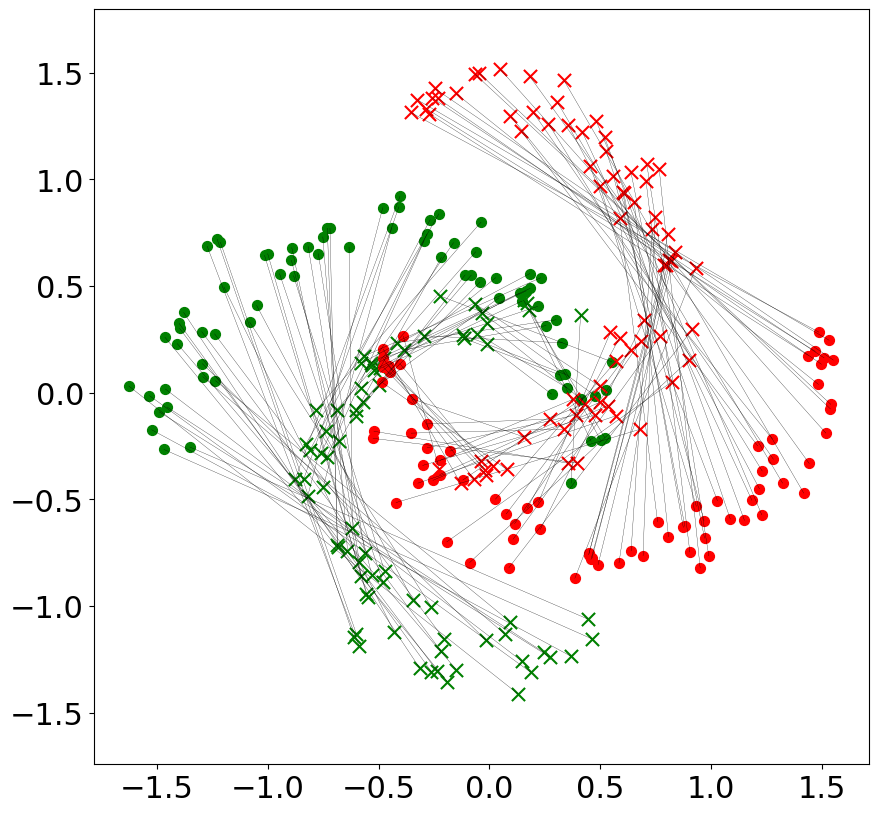

Plotting results
T Loss: 0.47906365990638733
D Loss: -0.016401711851358414


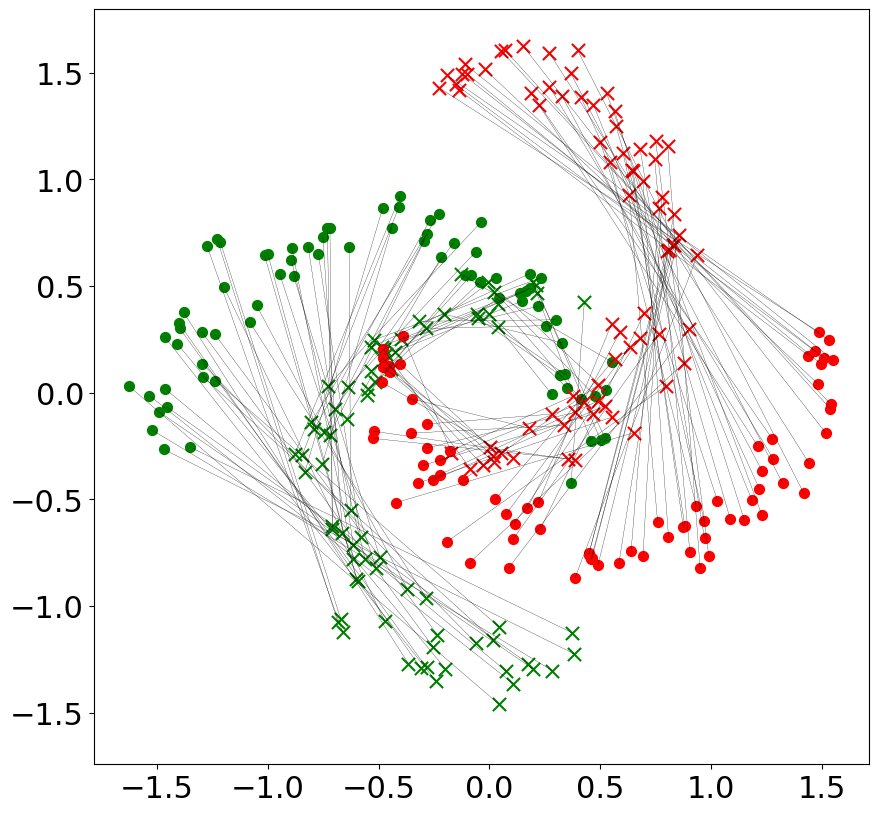

Plotting results
T Loss: 0.5589810609817505
D Loss: -0.03241201117634773


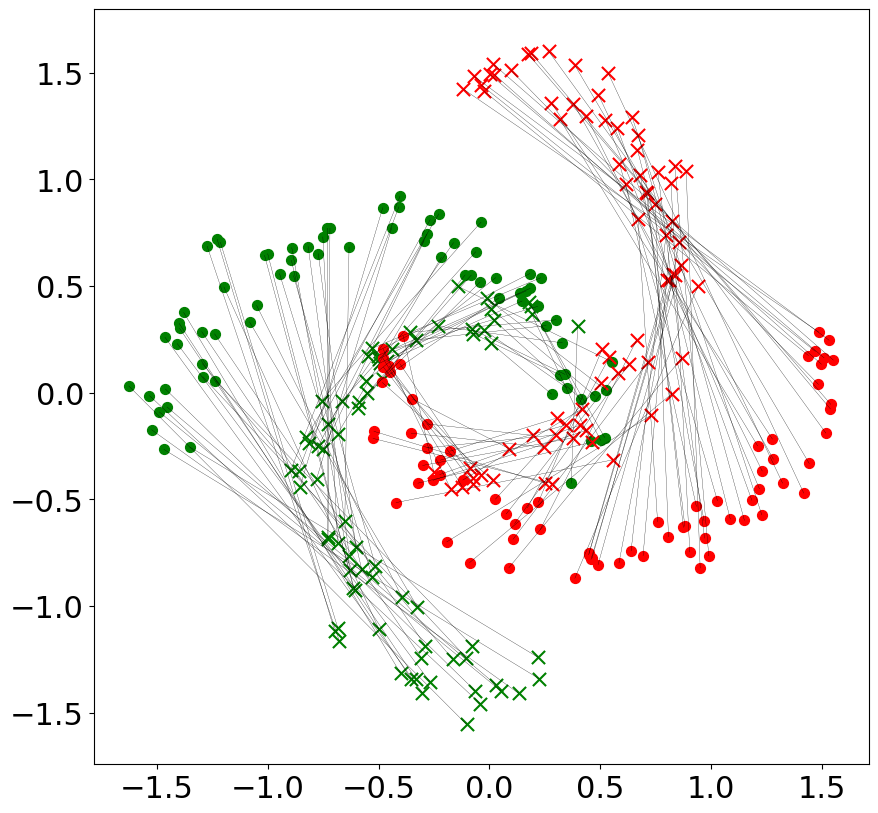

Plotting results
T Loss: 0.3154017925262451
D Loss: 0.00405602902173996


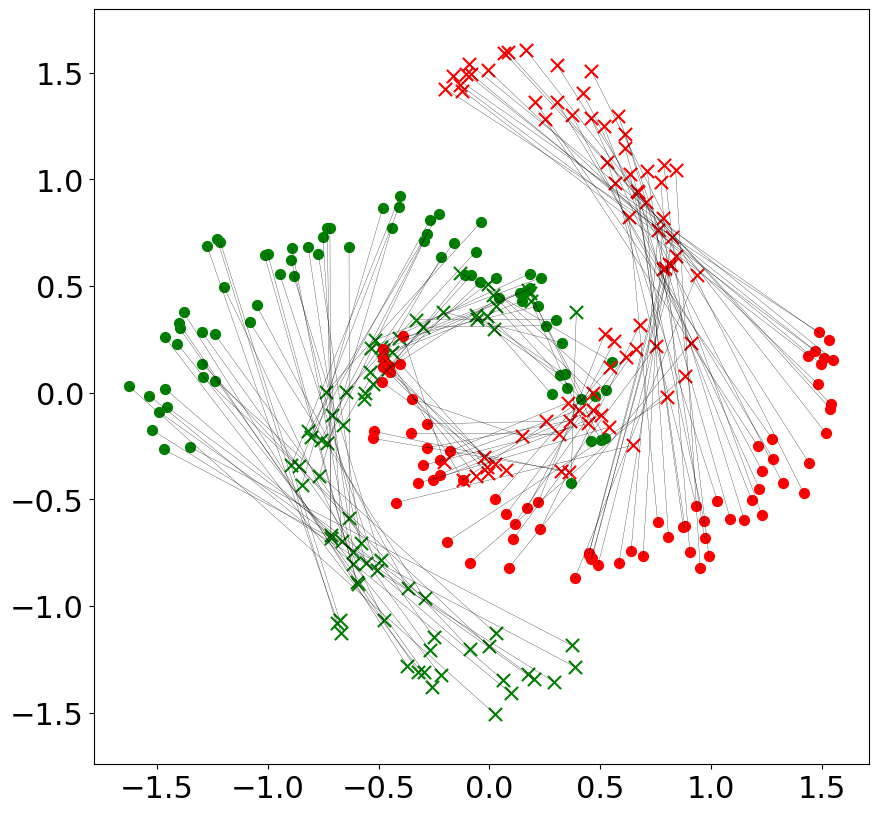

In [8]:
for step in tqdm(range(MAX_STEPS)):
    unfreeze(T); freeze(D)
    for t_iter in range(T_ITERS): 
        T_opt.zero_grad()
        X, Y = T_XY_sampler.sample(BATCH_SIZE)
        T_X = T(X.flatten(start_dim=0, end_dim=1)).permute(1,0).reshape(2, -1, С_SIZE).permute(1,2,0)
        T_var = .5 * torch.cdist(T_X, T_X).mean() * С_SIZE / (С_SIZE-1)
        cost = (Y-T_X).norm(dim=2).mean()
        T_loss = cost - T_var - D(T_X.flatten(start_dim=0, end_dim=1)).mean()
        T_loss.backward(); T_opt.step()

    gc.collect(); torch.cuda.empty_cache()
    freeze(T); unfreeze(D)
    X,_ = T_XY_sampler.sample(BATCH_SIZE)
    _, Y = D_XY_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        T_X = T(X.flatten(start_dim=0, end_dim=1)) 
    Y = torch.squeeze(Y)
    D_opt.zero_grad()
    D_loss = D(T_X).mean() - D(Y).mean()
    D_loss.backward(); D_opt.step();

    if step % PLOT_INTERVAL == 0:
        print('Plotting results')
        print('T Loss:',T_loss.item())
        print('D Loss:',D_loss.item())
        plot_twomoon(xs_test, xt_test, T=T, show_lines = True, name='Energy'+str(step))

    del D_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()